# Time Series Forecasting with LSTM-generator

On this notebook, we will try to predict the alcohol sales for unknown future for 1 month using LSTM-generator. 
You can find more informations about data in that site:
* https://fred.stlouisfed.org/series/S4248SM144NCEN


Let's import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 


import os
print(os.listdir("../input"))

['S4248SM144NCEN.csv']


In [2]:
df = pd.read_csv('../input/S4248SM144NCEN.csv', index_col= 'DATE', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 1992-01-01 to 2019-04-01
Freq: MS
Data columns (total 1 columns):
S4248SM144NCEN    328 non-null int64
dtypes: int64(1)
memory usage: 5.1 KB


In [4]:
df.columns= ['Sales']

In [5]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


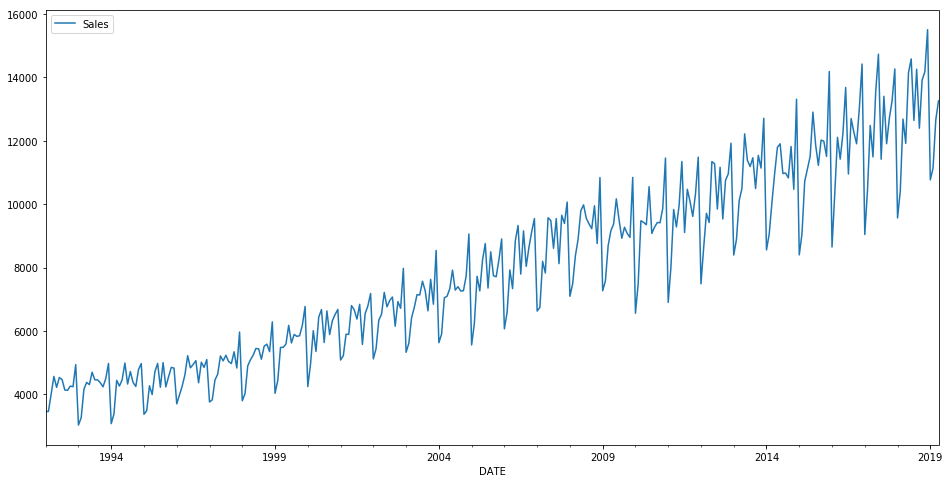

In [6]:
df.plot(figsize=(16,8))

As we can see, we have 17 years sale data. And this data is acting like time series data.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
result= seasonal_decompose(df['Sales'])

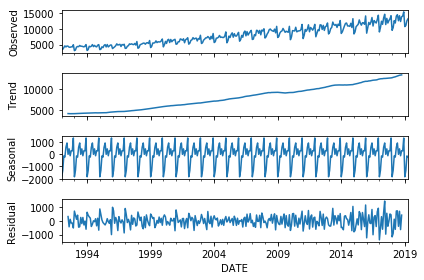

In [9]:
result.plot();

In [10]:
len(df)

328

In [11]:
train = df.iloc[:316]
test= df.iloc[316:]

In [12]:
test= test[0:12]

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2018-05-01 to 2019-04-01
Freq: MS
Data columns (total 1 columns):
Sales    12 non-null int64
dtypes: int64(1)
memory usage: 192.0 bytes


In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
scaled_train = scaler.transform(train)

In [18]:
scaled_test = scaler.transform(test) 

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [20]:
len(scaled_train)

316

Now, we will start to create LSTM model for forecasting.

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [22]:
n_input = 12
n_feature = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)

In [23]:
model = Sequential()

model.add(LSTM(128,activation = 'relu', input_shape= (n_input, n_feature), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 128)           66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit_generator(train_generator,epochs= 50)

Epoch 1/50
304/304 [==============================] - 6s 18ms/step - loss: 0.0198
Epoch 2/50
304/304 [==============================] - 4s 15ms/step - loss: 0.0108
Epoch 3/50
304/304 [==============================] - 4s 14ms/step - loss: 0.0095
Epoch 4/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0093
Epoch 5/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0085
Epoch 6/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0073
Epoch 7/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0049
Epoch 8/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0047
Epoch 9/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0034
Epoch 10/50
304/304 [==============================] - 4s 14ms/step - loss: 0.0031
Epoch 11/50
304/304 [==============================] - 4s 15ms/step - loss: 0.0032
Epoch 12/50
304/304 [==============================] - 4s 15ms/step - loss: 0.0023
Epoch 13/50
3

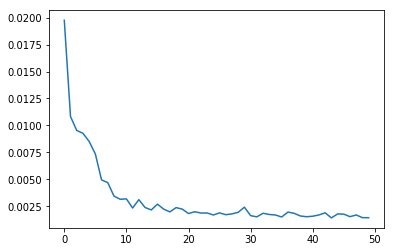

In [26]:
my_loss= model.history.history['loss']
plt.plot(range(len(my_loss)),my_loss)

In [27]:
first_eval_batch = scaled_train[-12:]

In [28]:
first_eval_batch

array([[0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ],
       [0.63116506],
       [0.82502778],
       [0.75972305]])

In [29]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_feature))

In [30]:
model.predict(first_eval_batch)

array([[1.0206845]], dtype=float32)

# Forecast Using RNN Model

In [31]:
#holding my predictions
test_predictions = []


# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format RNN wants (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((1,n_input,n_feature))

#how far into the future will I forecast?

for i in range(len(test)):
    
    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    #store that prediction
    test_predictions.append(current_pred)
    
    # UPDATE current batch o include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

In [32]:
test_predictions

[array([1.0206845], dtype=float32),
 array([1.0935327], dtype=float32),
 array([0.8568886], dtype=float32),
 array([0.9816308], dtype=float32),
 array([0.8675723], dtype=float32),
 array([0.93588126], dtype=float32),
 array([0.9909237], dtype=float32),
 array([1.0519187], dtype=float32),
 array([0.65794545], dtype=float32),
 array([0.7754931], dtype=float32),
 array([0.9207505], dtype=float32),
 array([0.9337127], dtype=float32)]

In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
true_predictions

array([[14971.98773932],
       [15824.23884046],
       [13055.73964065],
       [14515.09875441],
       [13180.72842646],
       [13979.87482631],
       [14623.81639808],
       [15337.39739823],
       [10728.30386776],
       [12103.49360591],
       [13802.86008513],
       [13954.50512147]])

In [35]:
test['Predictions'] =true_predictions

In [36]:
test.head()

,Sales,Predictions
DATE,,
2018-05-01,14138,14971.987739
2018-06-01,14583,15824.238840
2018-07-01,12640,13055.739641
2018-08-01,14257,14515.098754
2018-09-01,12396,13180.728426


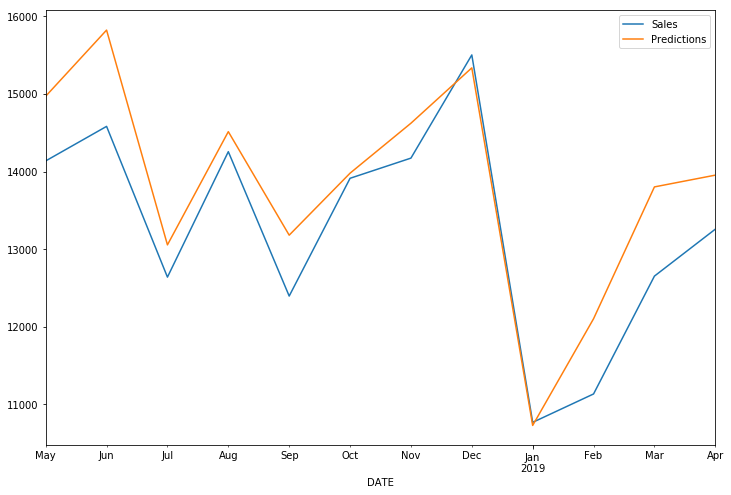

In [37]:
test.plot(figsize=(12,8))

In [38]:
model.save('mycoolmodel.h5')

Our model is not bad!

Thanks:) If you like it please vote. 